## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [2]:
!nvidia-smi

Mon Mar 11 19:33:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8               1W /  50W |      6MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# import torchtext

# import spacy

import random
import math
import time
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from tokenizers import Tokenizer, pre_tokenizers, normalizers, decoders
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import Lowercase, StripAccents
import torchnlp.nn

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed);

### Data preprocessing
__Here comes the preprocessing.__

In [3]:
with open("data.txt") as f:
    data = [s.rstrip().split("\t") for s in f]


size = len(data)
train_size = int(0.8 * size)
test_size = int(0.15 * size)
val_size = int(0.05 * size)
train_data, test_data, val_data = random_split(data, [train_size, test_size, val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [4]:
src_tokenizer = Tokenizer(WordPiece(unk_token='<unk>'))
trg_tokenizer = Tokenizer(WordPiece(unk_token='<unk>'))

src_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])
trg_tokenizer.normalizer = normalizers.Sequence([Lowercase(), StripAccents()])

src_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=True)])
trg_tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

src_tokenizer.decoder = decoders.WordPiece()
trg_tokenizer.decoder = decoders.WordPiece()

src_trainer = WordPieceTrainer(special_tokens=['<unk>', '<sos>', '<pad>', '<eos>'], vocab_size=10000)
trg_trainer = WordPieceTrainer(special_tokens=['<unk>', '<sos>', '<pad>', '<eos>'], vocab_size=10000)

src_tokenizer.train_from_iterator([x[0] for x in train_data], trainer=src_trainer)
trg_tokenizer.train_from_iterator([x[1] for x in train_data], trainer=trg_trainer)


print(f"Source (en) vocabulary size: {src_tokenizer.get_vocab_size()}")
print(f"Target (ru) vocabulary size: {trg_tokenizer.get_vocab_size()}")







Source (en) vocabulary size: 10000
Target (ru) vocabulary size: 10000


In [5]:
tokenized_data = [[src_tokenizer.encode(x[0]).tokens, trg_tokenizer.encode(x[1]).tokens] for x in data]
print(tokenized_data[0][0])
print(tokenized_data[0][1])
print(tokenized_data[1][0])
print(tokenized_data[1][1])

['cord', '##eli', '##a', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']
['отель', 'cor', '##de', '##lia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свят', '##о', '-', 'тро', '##иц', '##кого', 'собора', '.']
['at', 'tu', '##p', '##ir', '##mark', '##a', 'lodge', 'you', 'will', 'find', 'a', '2', '4', '-', 'hour', 'front', 'desk', ',', 'room', 'service', ',', 'and', 'a', 'snack', 'bar', '.']
['в', 'числе', 'удобств', 'лоджа', 't', '##up', '##ir', '##mark', '##a', 'круглосуточная', 'стойка', 'регистрации', 'и', 'снэк', '-', 'бар', '.', 'гости', 'могут', 'воспользоваться', 'услугой', 'доставки', 'еды', 'и', 'напитков', 'в', 'номер', '.']


Let's check the length distributions:

Length distribution in dataset


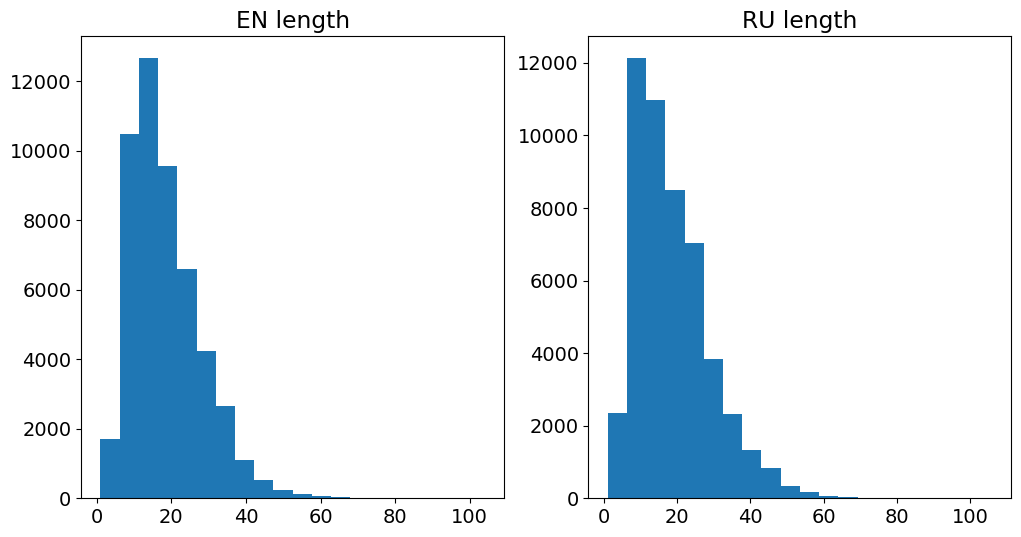

In [6]:
src_length = map(len, [x[0] for x in tokenized_data])
trg_length = map(len, [x[1] for x in tokenized_data])

print('Length distribution in dataset')
plt.figure(figsize=[12, 6])
plt.subplot(1, 2, 1)
plt.title("EN length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("RU length")
plt.hist(list(trg_length), bins=20);

In [7]:
src_unk_token_id, src_sos_token_id, src_pad_token_id, src_eos_token_id = [src_tokenizer.token_to_id(token) for token in ['<unk>', '<sos>', '<pad>', '<eos>']]
trg_unk_token_id, trg_sos_token_id, trg_pad_token_id, trg_eos_token_id = [trg_tokenizer.token_to_id(token) for token in ['<unk>', '<sos>', '<pad>', '<eos>']]



def collate(batch):
    src_batch, trg_batch = [], []
    for src, trg in batch:
        src_processed = [src_sos_token_id] + src_tokenizer.encode(src).ids + [src_eos_token_id]
        src_batch.append(torch.tensor(src_processed))

        trg_processed = [trg_sos_token_id] + trg_tokenizer.encode(trg).ids + [trg_eos_token_id]
        trg_batch.append(torch.tensor(trg_processed))

    src_padded = pad_sequence(src_batch, padding_value=src_pad_token_id)
    trg_padded = pad_sequence(trg_batch, padding_value=trg_pad_token_id)
    return src_padded, trg_padded


batch_size = 64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate)

src_batch, trg_batch = next(iter(train_dataloader))
print(src_batch.shape, trg_batch.shape)

torch.Size([37, 64]) torch.Size([37, 64])


### Model side
__Here comes simple pipeline of NMT model learning.__

In [8]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
def train(model, train_dataloader, optimizer, criterion, clip, loss_history):
    model.train()

    epoch_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        loss_history.append(loss.cpu().data.numpy())


    return epoch_loss / len(train_dataloader)



def evaluate(model, val_dataloader, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, trg in val_dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def init_weights(m):
    for name, param in m.named_parameters():
        if param.dim() > 1:
          nn.init.xavier_uniform_(param)
        else:
          nn.init.uniform_(param, -0.08, 0.08)



def train_model(model, optimizer, criterion, CLIP, N_EPOCHS, train_dataloader, val_dataloader, file_name):
    best_valid_loss = float('inf')
    loss_history = []
    train_history = []
    valid_history = []
    total_time = 0
    

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, loss_history)
        valid_loss = evaluate(model, val_dataloader, criterion)

        end_time = time.time()

        total_time = total_time + end_time - start_time

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), file_name)

        train_history.append(train_loss)
        valid_history.append(valid_loss)


        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    ax[1].set_xlabel('Epoch')
    ax[0].plot(loss_history, label='train loss')
    ax[1].plot(train_history, label='general train history')
    ax[1].plot(valid_history, label='general valid history')
    plt.legend()

    plt.show()

    epoch_mins, epoch_secs = epoch_time(0, total_time)
    print(f'Total time: {epoch_mins}m {epoch_secs}s')



def translation_examples(model, device='cpu'):
    model.eval()
    for idx in range(5):
        src = src_batch[:, idx:idx+1]
        trg = trg_batch[:, idx:idx+1]
        generate_translation(src, trg, model, TRG_vocab, device)



def bleu_score(model):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for src, trg in test_dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG_vocab) for x in output[1:].detach().cpu().numpy().T])

    # original_text = flatten(original_text)
    # generated_text = flatten(generated_text)
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

# Model quality

Here comes comparing the quality of different models



## Baseline model

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):        
        embedded = self.dropout(self.embedding(src))        
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0,:]
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

In [11]:
INPUT_DIM = src_tokenizer.get_vocab_size()
OUTPUT_DIM = trg_tokenizer.get_vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,606,416 trainable parameters


Epoch: 01 | Time: 4m 7s
	Train Loss: 5.032 | Train PPL: 153.279
	 Val. Loss: 6.212 |  Val. PPL: 498.845
Epoch: 02 | Time: 4m 7s
	Train Loss: 4.534 | Train PPL:  93.142
	 Val. Loss: 6.015 |  Val. PPL: 409.658
Epoch: 03 | Time: 4m 4s
	Train Loss: 4.251 | Train PPL:  70.149
	 Val. Loss: 5.907 |  Val. PPL: 367.491
Epoch: 04 | Time: 4m 6s
	Train Loss: 4.063 | Train PPL:  58.160
	 Val. Loss: 5.902 |  Val. PPL: 365.872
Epoch: 05 | Time: 4m 5s
	Train Loss: 3.932 | Train PPL:  51.027
	 Val. Loss: 5.875 |  Val. PPL: 356.158
Epoch: 06 | Time: 4m 6s
	Train Loss: 3.786 | Train PPL:  44.068
	 Val. Loss: 5.864 |  Val. PPL: 352.167
Epoch: 07 | Time: 4m 6s
	Train Loss: 3.677 | Train PPL:  39.538
	 Val. Loss: 5.828 |  Val. PPL: 339.784
Epoch: 08 | Time: 4m 7s
	Train Loss: 3.574 | Train PPL:  35.647
	 Val. Loss: 5.757 |  Val. PPL: 316.421
Epoch: 09 | Time: 4m 5s
	Train Loss: 3.503 | Train PPL:  33.221
	 Val. Loss: 5.870 |  Val. PPL: 354.400
Epoch: 10 | Time: 4m 7s
	Train Loss: 3.422 | Train PPL:  30.634


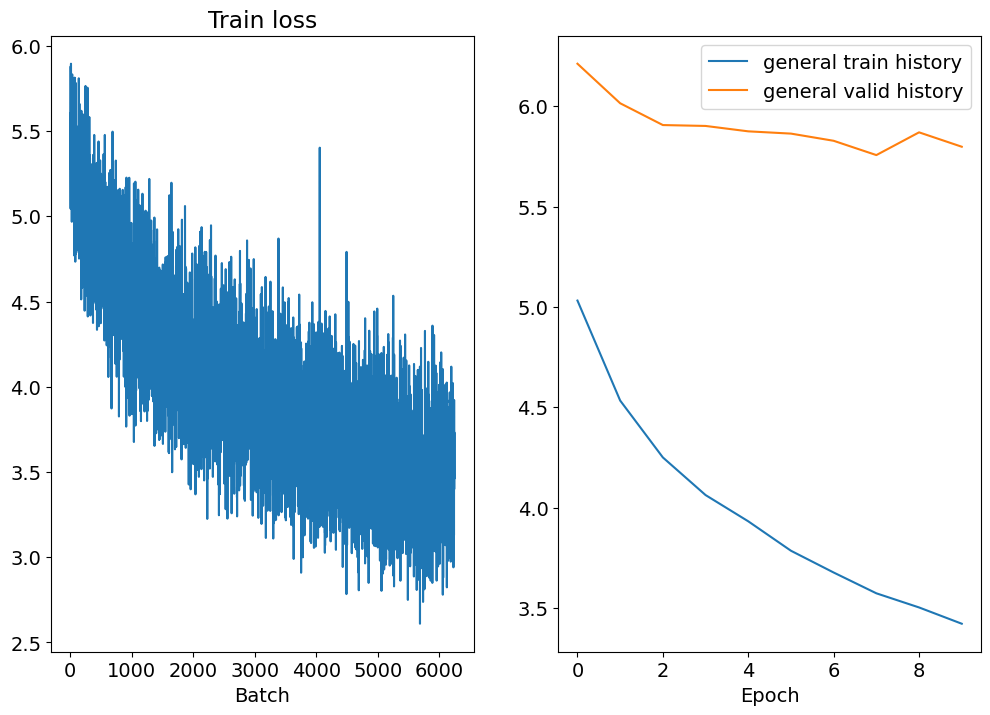

Total time: 41m 5s


In [13]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index = trg_pad_token_id),
            CLIP=1,
            N_EPOCHS=10,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='baseline.pt')

In [43]:
translation_examples(model, device)

Original: в собственной ванной комнате предоставляются туалетно - косметические принадлежности и фен .
Generated: в собственной ванной комнате предоставляются бесплатные туалетно - косметические принадлежности и фен .

Original: до магазинов и ресторанов 700 метров .
Generated: в 200 метрах от апартаментов работают супермаркет и рестораны .

Original: апартаменты « трускавец » находятся в городе трускавец , в 18 минутах ходьбы от железнодорожного вокзала .
Generated: апартаменты расположены в городе , в в минутах ходьбы от железнодорожного вокзала .

Original: на территории апартаментов работает ресторан can , в котором гостям предложат блюда средиземноморской кухни .
Generated: в ресторане работает ресторан , где подают блюда блюда и интернациональной кухни .

Original: предоставляется бесплатный wi - fi на всей территории и бесплатная частная парковка .
Generated: к услугам гостей бесплатный wi - fi и бесплатная частная парковка .



In [44]:
bleu_score(model)

14.789285414978186

## Attention

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden


class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention = torchnlp.nn.Attention(hid_dim)
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, encoder_outputs, hidden):
        input = input.unsqueeze(dim=0)
        embedded = self.dropout(self.embedding(input))

        context, _ = self.attention(hidden[-1].unsqueeze(1), encoder_outputs.swapaxes(0, 1))
        context = context.swapaxes(0, 1)

        rnn_input = torch.cat((embedded, context), dim=-1)
        output, hidden = self.rnn(rnn_input, hidden)
        pred = self.out(output.squeeze(dim=0))
        return pred, hidden
      


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        preds = []
        encoder_outputs, hidden = self.encoder(src)

        # First input to the decoder is the <sos> token.
        input = trg[0, :]
        for i in range(1, trg_len):
            pred, hidden = self.decoder(input, encoder_outputs, hidden)
            preds.append(pred)
            teacher_force = random.random() < teacher_forcing_ratio
            _, top_pred = pred.max(dim=1)
            input = trg[i, :] if teacher_force else top_pred

        return torch.stack(preds)

In [12]:
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = my_network.Encoder(src_tokenizer.get_vocab_size(), ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = my_network.Decoder(trg_tokenizer.get_vocab_size(), DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)


model = my_network.Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,973,200 trainable parameters


Epoch: 01 | Time: 2m 59s
	Train Loss: 5.339 | Train PPL: 208.262
	 Val. Loss: 6.146 |  Val. PPL: 467.075
Epoch: 02 | Time: 2m 58s
	Train Loss: 4.881 | Train PPL: 131.769
	 Val. Loss: 6.088 |  Val. PPL: 440.601
Epoch: 03 | Time: 2m 57s
	Train Loss: 4.595 | Train PPL:  98.948
	 Val. Loss: 6.005 |  Val. PPL: 405.426
Epoch: 04 | Time: 2m 59s
	Train Loss: 4.361 | Train PPL:  78.307
	 Val. Loss: 5.935 |  Val. PPL: 377.878
Epoch: 05 | Time: 2m 58s
	Train Loss: 4.230 | Train PPL:  68.688
	 Val. Loss: 5.951 |  Val. PPL: 384.246
Epoch: 06 | Time: 2m 59s
	Train Loss: 4.107 | Train PPL:  60.743
	 Val. Loss: 5.875 |  Val. PPL: 355.967
Epoch: 07 | Time: 2m 58s
	Train Loss: 4.015 | Train PPL:  55.402
	 Val. Loss: 5.860 |  Val. PPL: 350.734
Epoch: 08 | Time: 2m 57s
	Train Loss: 3.927 | Train PPL:  50.756
	 Val. Loss: 5.754 |  Val. PPL: 315.314
Epoch: 09 | Time: 3m 0s
	Train Loss: 3.850 | Train PPL:  46.992
	 Val. Loss: 5.833 |  Val. PPL: 341.304
Epoch: 10 | Time: 2m 56s
	Train Loss: 3.782 | Train PPL:

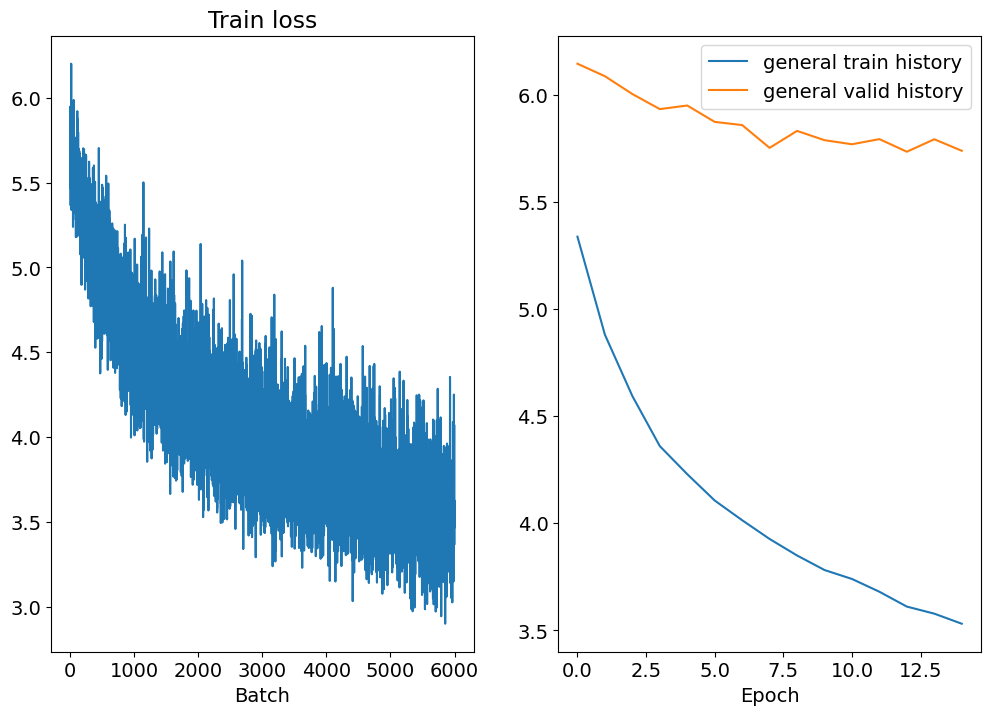

Total time: 44m 56s


In [14]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index=trg_tokenizer.token_to_id('<pad>')),
            CLIP=1,
            N_EPOCHS=15,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='attention.pt')

In [21]:
bleu_score(model)

25.23526642496823


## Transformer

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, trg_vocab_size, dim_feedforward = 512, dropout=0.1):
        super().__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, trg_vocab_size)
        self.src_token_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.trg_token_emb = TokenEmbedding(trg_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src, trg, src_mask=None, trg_mask=None, src_padding_mask=None, trg_padding_mask=None, memory_key_padding_mask=None):
        src_emb = self.positional_encoding(self.src_token_emb(src))
        trg_emb = self.positional_encoding(self.trg_token_emb(trg))
        outs = self.transformer(src_emb, trg_emb, src_mask, trg_mask, None, src_padding_mask, trg_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask=None):
        return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

    def decode(self, trg, memory, trg_mask=None):
        return self.transformer.decoder(self.positional_encoding(self.trg_token_emb(trg)), memory, trg_mask)


def generate_square_subsequent_mask(sz, device):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, trg, device):
    src_seq_len = src.shape[0]
    trg_seq_len = trg.shape[0]

    trg_mask = generate_square_subsequent_mask(trg_seq_len, device)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == src_tokenizer.token_to_id('<pad>')).transpose(0, 1)
    trg_padding_mask = (trg == trg_tokenizer.token_to_id('<pad>')).transpose(0, 1)
    return src_mask, trg_mask, src_padding_mask, trg_padding_mask

In [19]:
model = Seq2SeqTransformer(2, 2, 256, 4, src_tokenizer.get_vocab_size(), trg_tokenizer.get_vocab_size(), 256).to(device)
model.apply(init_weights)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,801,488 trainable parameters


/home/semyon/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
train_model(model,
            optimizer=optim.Adam(model.parameters()),
            criterion=nn.CrossEntropyLoss(ignore_index=trg_tokenizer.token_to_id('<pad>')),
            CLIP=1,
            N_EPOCHS=10,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            file_name='transformer.pt')

Both tokenization and attention provide quite a significant increase in translation quality